# Question 3: Simulation

Statistiques sommaires des rendements simulés :

                              Moyenne  Écart-type  Asymétrie  \
Normale standard               0.0237      1.0044    -0.0191   
Student-t (df=3, normalisée)  -0.0320      0.8979    -0.2371   

                              Aplatissement (kurtosis)  
Normale standard                                0.0188  
Student-t (df=3, normalisée)                   10.2730   



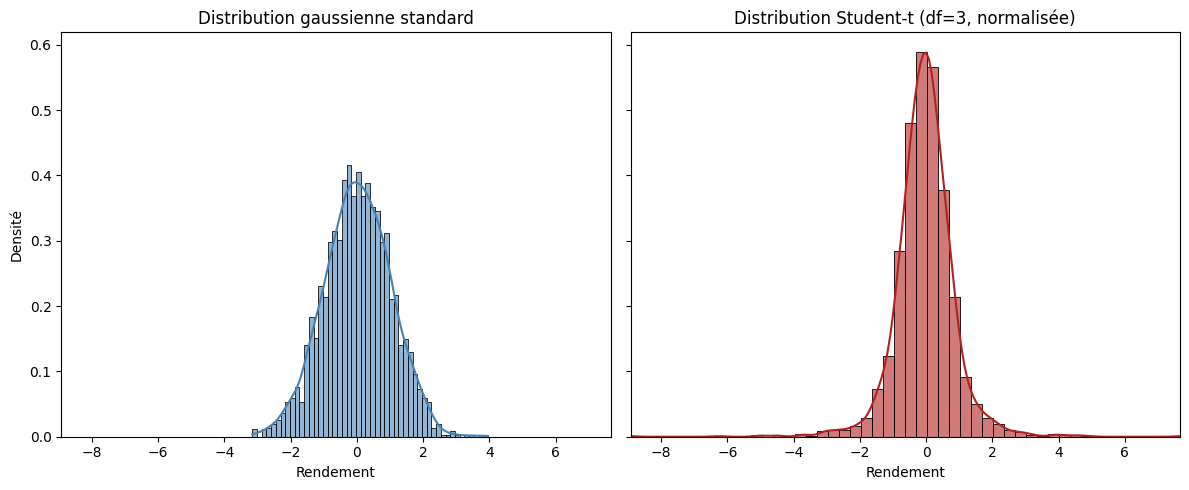

In [ ]:
# Partie a : Simulation des rendements selon une loi normale et une loi student-t normalisée

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis

# 1. Paramètres de simulation
n = 2500 # longueur des séries de rendements (déterminée de manière arbitraire)
df = 3 # degrés de liberté pour la Student-t (mentionnée dans l'énoncé)
np.random.seed(1) # Fixe la graine du générateur de nombres aléatoires pour que les résultats soient reproductibles (donc les mêmes à chaque exécution). Le nombre 1 a été choisi arbitrairement.

# 2. Génération des rendements
returns_normal = np.random.normal(loc=0, scale=1, size=n) # Normal (0,1)
returns_t = np.random.standard_t(df=df, size=n) # Student-t(df)

# 3. Normalisation de la variance
var_t_theoretical = df / (df - 2)  # variance théorique Student-t(df)
scale_factor = np.sqrt(1 / var_t_theoretical) # calcul de combien réduire l’échelle pour normaliser la variance à 1
returns_t_scaled = returns_t * scale_factor  # application de la réduction d'échelle

# 4. Statistiques sommaires
def summary_stats(data):
    return {
        "Moyenne": np.mean(data),
        "Écart-type": np.std(data, ddof=1),
        "Asymétrie": skew(data),
        "Aplatissement (kurtosis)": kurtosis(data, fisher=True)}

stats_normal = summary_stats(returns_normal)
stats_t = summary_stats(returns_t_scaled)

summary_df = pd.DataFrame([stats_normal, stats_t], index=["Normale standard", "Student-t (df=3, normalisée)"])

print("Statistiques sommaires des rendements simulés :\n")
print(summary_df.round(4), "\n")

# 5. Visualisation : deux graphiques côte à côte avec mêmes axes afin de faciliter la comparaison
# Déterminer les mêmes limites sur x et y
x_min = min(returns_normal.min(), returns_t_scaled.min())
x_max = max(returns_normal.max(), returns_t_scaled.max())

# Préparer la figure
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# Graphique 1 : Normale
sns.histplot(returns_normal, bins=50, kde=True, stat="density", color="steelblue", alpha=0.6, ax=axes[0])
axes[0].set_title("Distribution gaussienne standard")
axes[0].set_xlabel("Rendement")
axes[0].set_ylabel("Densité")
axes[0].set_xlim(x_min, x_max)

# Graphique 2 : Student-t
sns.histplot(returns_t_scaled, bins=50, kde=True, stat="density", color="firebrick", alpha=0.6, ax=axes[1])
axes[1].set_title("Distribution Student-t (df=3, normalisée)")
axes[1].set_xlabel("Rendement")
axes[1].set_ylabel("Densité")
axes[1].set_xlim(x_min, x_max)

# Ajustement de la mise en page
plt.tight_layout()
plt.show()


In [26]:
# Partie b : Calcul de la VaR et du déficit attendu (ES) de 3 différentes manières

import numpy as np
import pandas as pd
from scipy.stats import norm, t

alpha = 0.05  # niveau pour VaR/ES
nu = 3        # degrés de liberté pour l'approche t

# Méthodes de calcul VaR / ES
# (i) Empirique
def var_es_empirique(x, a=alpha):
    var_ = np.quantile(x, a)
    es_  = x[x <= var_].mean() if np.any(x <= var_) else np.nan
    return var_, es_

# (ii) Paramétrique gaussienne
def var_es_gauss(x, a=alpha):
    mu, sig = np.mean(x), np.std(x, ddof=1)
    z = norm.ppf(a)
    var_ = mu + sig * z
    es_  = mu - sig * norm.pdf(z) / a
    return var_, es_

# (iii) Paramétrique t (df connus)
def var_es_t(x, a=alpha, df=nu):
    """
    Modèle: R = mu + sigma * Z, avec Var(Z)=1 et Z ~ t(df) standardisée.
    Pour Y ~ t_df (scale=1): Var(Y)=df/(df-2), donc Z = c*Y, c = sqrt((df-2)/df).
    ES(Y | Y<=q) = - ((df + q^2)/((df-1)*a)) * f_t(q)
    """
    mu, sig = np.mean(x), np.std(x, ddof=1)
    q_y = t.ppf(a, df=df)       # quantile de Y
    f_y = t.pdf(q_y, df=df)     # densité en q_y
    c = np.sqrt((df - 2) / df)  # normalise à Var=1

    var_z = c * q_y
    es_y  = - (df + q_y**2) / ((df - 1) * a) * f_y
    es_z  = c * es_y

    var_ = mu + sig * var_z
    es_  = mu + sig * es_z
    return var_, es_

# Construction d'un tableau récapitulatif pour chaque méthode
def table_empirique(series_dict, a=alpha):
    rows = []
    for nom, x in series_dict.items():
        v, e = var_es_empirique(np.asarray(x), a=a)
        rows.append({"Série": nom, "VaR 5%": v, "ES 5%": e})
    return pd.DataFrame(rows)

def table_gaussienne(series_dict, a=alpha):
    rows = []
    for nom, x in series_dict.items():
        v, e = var_es_gauss(np.asarray(x), a=a)
        rows.append({"Série": nom, "VaR 5%": v, "ES 5%": e})
    return pd.DataFrame(rows)

def table_student(series_dict, a=alpha, df=nu):
    rows = []
    for nom, x in series_dict.items():
        v, e = var_es_t(np.asarray(x), a=a, df=df)
        rows.append({"Série": nom, "VaR 5%": v, "ES 5%": e})
    return pd.DataFrame(rows)

# Utilisation des séries simulées précedemment
series = {
    "Distribution gaussienne standard": returns_normal,
    f"Distribution de Student-t (df={nu})": returns_t_scaled,}

# Calcul des tableaux récapitulatifs
tbl_empirique = table_empirique(series).round(4)
tbl_gauss     = table_gaussienne(series).round(4)
tbl_student   = table_student(series, df=nu).round(4)

print("\nMéthode (i) : Quantile empirique ")
print(tbl_empirique.to_string(index=False))

print("\nMéthode (ii) : Paramétrique gaussienne")
print(tbl_gauss.to_string(index=False))

print(f"\nMéthode (iii) : Paramétrique t (df={nu})")
print(tbl_student.to_string(index=False))



Méthode (i) : Quantile empirique 
                           Série  VaR 5%   ES 5%
Distribution gaussienne standard -1.6184 -2.0752
Distribution de Student-t (df=3) -1.3202 -2.1141

Méthode (ii) : Paramétrique gaussienne
                           Série  VaR 5%   ES 5%
Distribution gaussienne standard -1.6284 -2.0481
Distribution de Student-t (df=3) -1.5090 -1.8842

Méthode (iii) : Paramétrique t (df=3)
                           Série  VaR 5%   ES 5%
Distribution gaussienne standard  -1.341 -2.2230
Distribution de Student-t (df=3)  -1.252 -2.0405


VaR 5% (échantillon original) : -1.320163
IC 95% (bootstrap percentile) : [-1.421926, -1.209987]


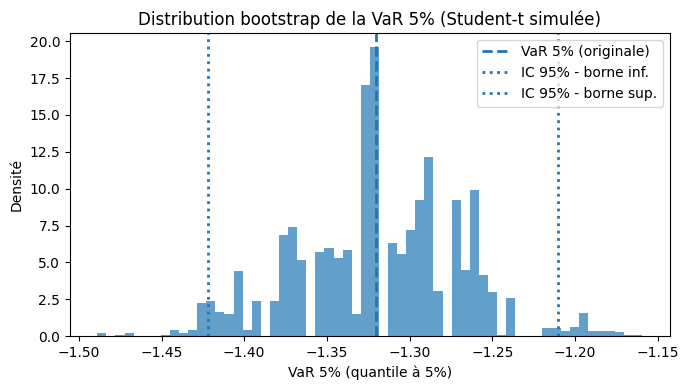

In [24]:
# Partie c : Bootstrap de la VaR empirique (5%) à partir de la série Student-t simulée

import numpy as np
import matplotlib.pyplot as plt

alpha = 0.05          # niveau de VaR (queue gauche)
B = 2500            # nombre de rééchantillonnages
rng = np.random.default_rng(11)  # graine pour reproductibilité

# On réutilise le 'returns_t_scaled' de la partie a.
x = returns_t_scaled
n = x.size

# 1) VaR empirique sur l'échantillon original
var_hat = np.quantile(x, alpha)

# 2) Bootstrap (rééchantillonnage avec remise): On échantillonne des indices, puis on calcule la VaR 5% sur chaque pseudo-échantillon.
idx = rng.integers(low=0, high=n, size=(B, n))
x_boot = x[idx]                                    # shape (B, n)
var_boot = np.quantile(x_boot, alpha, axis=1)      # shape (B,)

# 3) Intervalle de confiance 95% (méthode percentile)
ci_low, ci_high = np.percentile(var_boot, [2.5, 97.5])

print(f"VaR 5% (échantillon original) : {var_hat:.6f}")
print(f"IC 95% (bootstrap percentile) : [{ci_low:.6f}, {ci_high:.6f}]")

# 4) Tracé de la distribution bootstrap
plt.figure(figsize=(7,4))
plt.hist(var_boot, bins=60, density=True, alpha=0.7)
plt.axvline(var_hat, linestyle="--", linewidth=2, label="VaR 5% (originale)")
plt.axvline(ci_low, linestyle=":", linewidth=2, label="IC 95% - borne inf.")
plt.axvline(ci_high, linestyle=":", linewidth=2, label="IC 95% - borne sup.")
plt.title("Distribution bootstrap de la VaR 5% (Student-t simulée)")
plt.xlabel("VaR 5% (quantile à 5%)")
plt.ylabel("Densité")
plt.legend()
plt.tight_layout()
plt.show()